<a href="https://colab.research.google.com/github/chillukamaripranaya143/Alzheimer_mini/blob/main/SE_RESNET%2BVGG(HYBRID).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle --quiet

# Upload your Kaggle API key
from google.colab import files
files.upload()  # Upload kaggle.json from your Kaggle account

# Setup Kaggle API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d ashrafulhossenakash/alzheimer-disease-dataset

# Unzip dataset
!unzip -q alzheimer-disease-dataset.zip -d /content/
!ls /content/Dataset


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ashrafulhossenakash/alzheimer-disease-dataset
License(s): CC0-1.0
 80% 276M/346M [00:06<00:01, 39.8MB/s]
100% 346M/346M [00:06<00:00, 58.0MB/s]
ls: cannot access '/content/Dataset': No such file or directory


In [2]:
# Requirements: tensorflow>=2.10, sklearn, matplotlib, seaborn
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input, models
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
base_dir = "/content/Alzheimer_Dataset_V2"   # change if needed
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Get class names
# class_names = train_ds.class_names
# print("Class Names:", class_names)

# Extract all labels from the training dataset
train_labels = np.concatenate([y for x, y in train_ds], axis=0)

# Count how many samples per class
unique, counts = np.unique(train_labels, return_counts=True)

# Print the counts
print("\n📊 Number of training samples per class:")
for cls, count in zip(class_names, counts):
    print(f"{cls}: {count}")


📊 Number of training samples per class:
MildDemented: 6272
ModerateDemented: 4524
NonDemented: 6720
VeryMildDemented: 6272


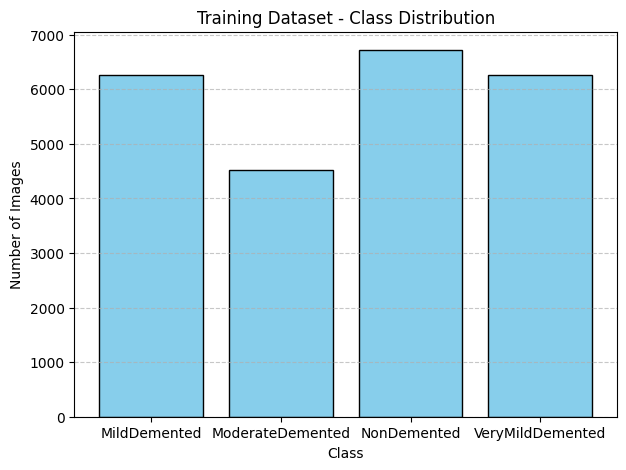

In [35]:
plt.figure(figsize=(7,5))

plt.bar(class_names, counts, color='skyblue', edgecolor='black')
plt.title("Training Dataset - Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


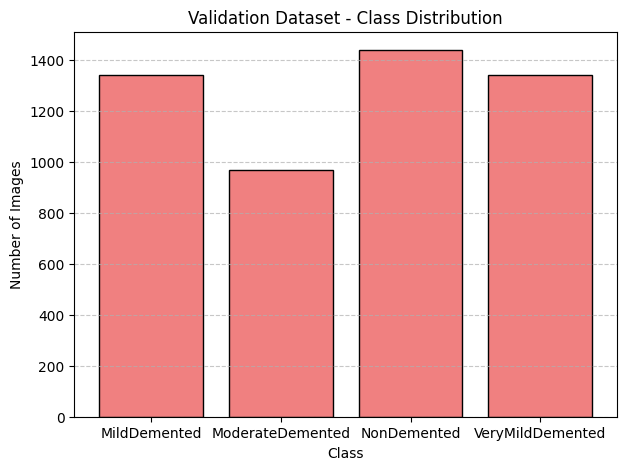

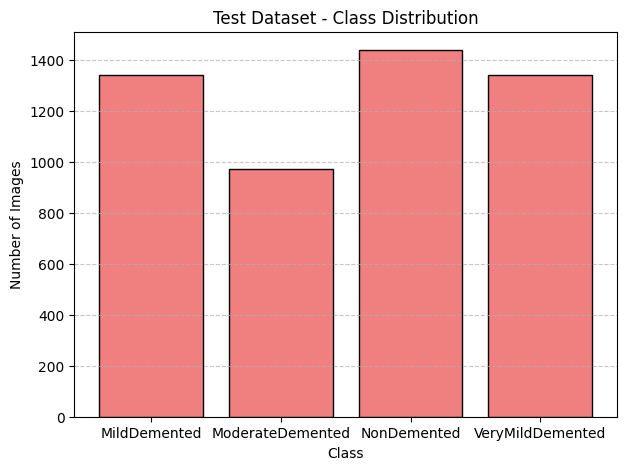

In [36]:
def plot_class_distribution(dataset, title):
    labels = np.concatenate([y for x, y in dataset], axis=0)
    unique, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(7,5))
    plt.bar([class_names[i] for i in unique], counts, color='lightcoral', edgecolor='black')
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_class_distribution(val_ds, "Validation Dataset - Class Distribution")
plot_class_distribution(test_ds, "Test Dataset - Class Distribution")


In [25]:
# ======================
# 1. DATASET SETUP
# ======================

img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, image_size=img_size, batch_size=batch_size, shuffle=True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir, image_size=img_size, batch_size=batch_size, shuffle=False
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, image_size=img_size, batch_size=batch_size, shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Detected Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

# ======================
# 2. DATA AUGMENTATION
# ======================
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.1),
])

Found 23788 files belonging to 4 classes.
Found 5097 files belonging to 4 classes.
Found 5099 files belonging to 4 classes.
Detected Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [26]:
# ======================
# 3. SE-RESNET50 FEATURE EXTRACTOR
# ======================
def squeeze_excite_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(filters // ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Multiply()([input_tensor, se])
    return se

def se_resnet50(input_shape=(224, 224, 3)):
    base = applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base.output
    x = squeeze_excite_block(x)
    x = layers.GlobalAveragePooling2D()(x)
    model = models.Model(inputs=base.input, outputs=x)
    return model


In [27]:
# ======================
# 4. VGG16 TOP LAYERS (PRETRAINED)
# ======================
def vgg16_top_layers():
    vgg = applications.VGG16(weights='imagenet', include_top=True)
    # Take only FC1 and FC2 (exclude softmax 1000)
    fc1 = vgg.get_layer('fc1')
    fc2 = vgg.get_layer('fc2')
    return fc1, fc2

In [28]:

# ======================
# 5. BUILD HYBRID MODEL
# ======================
input_shape = (224, 224, 3)
se_resnet = se_resnet50(input_shape)
fc1, fc2 = vgg16_top_layers()

inputs = layers.Input(shape=input_shape)
x = data_augmentation(inputs)
x = applications.resnet.preprocess_input(x)
x = se_resnet(x)

# Pass through pretrained VGG dense layers
x = layers.Dense(4096, activation='relu', name='vgg_fc1')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(4096, activation='relu', name='vgg_fc2')(x)
x = layers.Dropout(0.5)(x)

# Final Alzheimer classifier
outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

model = models.Model(inputs, outputs)

# ======================
# 6. COMPILE
# ======================
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# ======================
# 7. CALLBACKS
# ======================
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, verbose=1),
    ModelCheckpoint('best_hybrid_se_resnet_vgg.h5', monitor='val_accuracy',
                    save_best_only=True, verbose=1)
]


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 224, 224,  │          0 │ input_layer_16[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 224, 224)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 224, 224)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 224, 224)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 224, 224,  │          0 │ get_item_6[0][0], │
│                     │ 3)                │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 224, 224,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_8        │ (None, 2048)      │ 24,114,176 │ add_2[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg_fc1 (Dense)     │ (None, 4096)      │  8,392,704 │ functional_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 4096)      │          0 │ vgg_fc1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg_fc2 (Dense)     │ (None, 4096)      │ 16,781,312 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 4096)      │          0 │ vgg_fc2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predictions (Dense) │ (None, 4)         │     16,388 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,304,580 (188.08 MB)

 Trainable params: 49,251,460 (187.88 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [29]:
# ======================
# 8. TRAINING
# ======================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

# =====

Epoch 1/20
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.5744 - loss: 0.8989
Epoch 1: val_accuracy improved from -inf to 0.73671, saving model to best_hybrid_se_resnet_vgg.h5


744/744 ━━━━━━━━━━━━━━━━━━━━ 470s 579ms/step - accuracy: 0.5745 - loss: 0.8987 - val_accuracy: 0.7367 - val_loss: 0.6660 - learning_rate: 1.0000e-04
Epoch 2/20
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.8008 - loss: 0.4650
Epoch 2: val_accuracy improved from 0.73671 to 0.79831, saving model to best_hybrid_se_resnet_vgg.h5


744/744 ━━━━━━━━━━━━━━━━━━━━ 428s 575ms/step - accuracy: 0.8008 - loss: 0.4649 - val_accuracy: 0.7983 - val_loss: 0.5933 - learning_rate: 1.0000e-04
Epoch 3/20
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.8806 - loss: 0.3049
Epoch 3: val_accuracy improved from 0.79831 to 0.89955, saving model to best_hybrid_se_resnet_vgg.h5


744/744 ━━━━━━━━━━━━━━━━━━━━ 426s 573ms/step - accuracy: 0.8807 - loss: 0.3048 - val_accuracy: 0.8995 - val_loss: 0.2983 - learning_rate: 1.0000e-04
Epoch 4/20
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.9235 - loss: 0.1983
Epoch 4: val_accuracy improved from 0.89955 to 0.94919, saving model to best_hybrid_se_resnet_vgg.h5


744/744 ━━━━━━━━━━━━━━━━━━━━ 433s 582ms/step - accuracy: 0.9235 - loss: 0.1983 - val_accuracy: 0.9492 - val_loss: 0.1314 - learning_rate: 1.0000e-04
Epoch 5/20
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.9495 - loss: 0.1422
Epoch 5: val_accuracy did not improve from 0.94919
744/744 ━━━━━━━━━━━━━━━━━━━━ 422s 568ms/step - accuracy: 0.9495 - loss: 0.1422 - val_accuracy: 0.9445 - val_loss: 0.1906 - learning_rate: 1.0000e-04
Epoch 6/20
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.9611 - loss: 0.1131
Epoch 6: val_accuracy did not improve from 0.94919
744/744 ━━━━━━━━━━━━━━━━━━━━ 422s 567ms/step - accuracy: 0.9611 - loss: 0.1131 - val_accuracy: 0.9427 - val_loss: 0.1607 - learning_rate: 1.0000e-04
Epoch 7/20
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.9623 - loss: 0.1009
Epoch 7: val_accuracy did not improve from 0.94919
744/744 ━━━━━━━━━━━━━━━━━━━━ 422s 567ms/step - accuracy: 0.9624 - loss: 0.1009 - val_accuracy: 0.9355 - val_loss: 0.1898 - learning_rate

744/744 ━━━━━━━━━━━━━━━━━━━━ 435s 585ms/step - accuracy: 0.9855 - loss: 0.0390 - val_accuracy: 0.9953 - val_loss: 0.0132 - learning_rate: 3.0000e-05
Epoch 10/20
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.9938 - loss: 0.0171
Epoch 10: val_accuracy improved from 0.99529 to 0.99568, saving model to best_hybrid_se_resnet_vgg.h5


744/744 ━━━━━━━━━━━━━━━━━━━━ 434s 583ms/step - accuracy: 0.9938 - loss: 0.0171 - val_accuracy: 0.9957 - val_loss: 0.0119 - learning_rate: 3.0000e-05
Epoch 11/20
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.9933 - loss: 0.0179
Epoch 11: val_accuracy did not improve from 0.99568
744/744 ━━━━━━━━━━━━━━━━━━━━ 421s 566ms/step - accuracy: 0.9933 - loss: 0.0179 - val_accuracy: 0.9888 - val_loss: 0.0366 - learning_rate: 3.0000e-05
Epoch 12/20
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.9951 - loss: 0.0149
Epoch 12: val_accuracy did not improve from 0.99568
744/744 ━━━━━━━━━━━━━━━━━━━━ 421s 566ms/step - accuracy: 0.9951 - loss: 0.0149 - val_accuracy: 0.9941 - val_loss: 0.0162 - learning_rate: 3.0000e-05
Epoch 13/20
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.9952 - loss: 0.0138
Epoch 13: val_accuracy did not improve from 0.99568
744/744 ━━━━━━━━━━━━━━━━━━━━ 421s 566ms/step - accuracy: 0.9952 - loss: 0.0138 - val_accuracy: 0.9949 - val_loss: 0.0177 - learnin

744/744 ━━━━━━━━━━━━━━━━━━━━ 432s 581ms/step - accuracy: 0.9978 - loss: 0.0073 - val_accuracy: 0.9996 - val_loss: 0.0031 - learning_rate: 9.0000e-06
Epoch 16/20
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.9988 - loss: 0.0047
Epoch 16: val_accuracy did not improve from 0.99961
744/744 ━━━━━━━━━━━━━━━━━━━━ 421s 566ms/step - accuracy: 0.9988 - loss: 0.0047 - val_accuracy: 0.9990 - val_loss: 0.0043 - learning_rate: 9.0000e-06
Epoch 17/20
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.9977 - loss: 0.0056
Epoch 17: val_accuracy did not improve from 0.99961
744/744 ━━━━━━━━━━━━━━━━━━━━ 421s 566ms/step - accuracy: 0.9977 - loss: 0.0056 - val_accuracy: 0.9990 - val_loss: 0.0036 - learning_rate: 9.0000e-06
Epoch 18/20
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.9983 - loss: 0.0050
Epoch 18: val_accuracy did not improve from 0.99961
744/744 ━━━━━━━━━━━━━━━━━━━━ 421s 566ms/step - accuracy: 0.9983 - loss: 0.0050 - val_accuracy: 0.9988 - val_loss: 0.0039 - learnin

In [30]:

# ---------- EVALUATION ----------
print("Evaluating on test set...")
results = model.evaluate(test_ds)
print("Test loss, Test accuracy:", results)

Evaluating on test set...
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9999 - loss: 0.0013
Test loss, Test accuracy: [0.005189292598515749, 0.9992155432701111]


160/160 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step
                  precision    recall  f1-score   support

    MildDemented       1.00      1.00      1.00      1344
ModerateDemented       1.00      1.00      1.00       971
     NonDemented       1.00      1.00      1.00      1440
VeryMildDemented       1.00      1.00      1.00      1344

        accuracy                           1.00      5099
       macro avg       1.00      1.00      1.00      5099
    weighted avg       1.00      1.00      1.00      5099



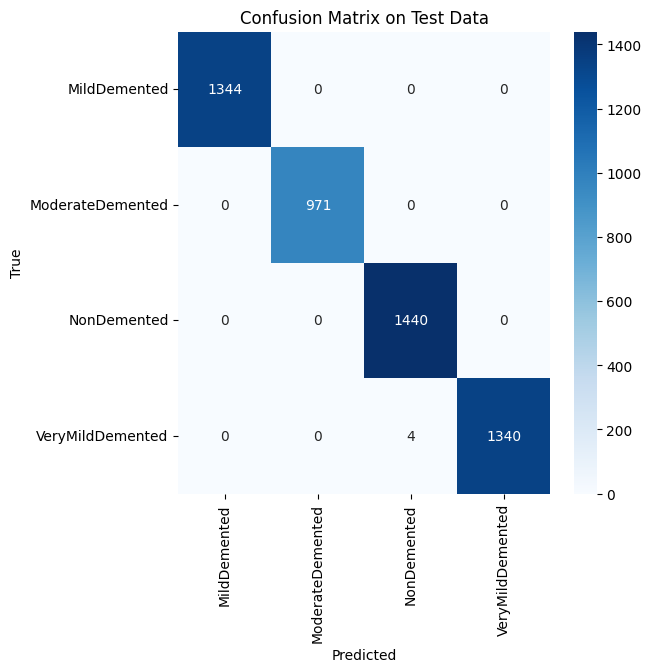

In [31]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get true & predicted labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Test Data")
plt.show()


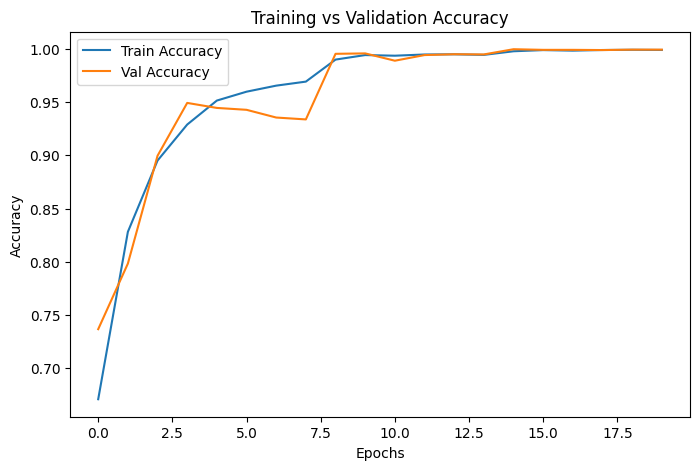

In [32]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


In [33]:
# Save the model in the native Keras format
model.save("SE_ResNet50_VGG(hybrid)_Alzheimer_Model.keras")

